Student Detail: 

Teng Guang Way G2101434F AI6101 Assignment March 2023





In [1]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```

## NOTICE!!!:  

The following environment class, CliffBoxGridWorld has been modified slightly to implement improved reward engineering. The reward engineering will encourage the agent to attempt more intelligent iterations by formulating the reward through a set of wider criteria. The reward engineering method is however, only activated in the final implementation's custom learning algorithm to further enhance its learning capability. (Faster learning rate with shortest trajectory with maximum possible cumulative reward. )

Modified part of the code are marked with the comment "NOTICE!!!"



In [2]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 rewardengineering=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos
        
        
        # NOTICE!!! --- Custom Code BEGIN HERE ----
        # New custom parameters for custom MDP Formulation of Reward, set to False to train RL algorithm with original formulation
        self.rewardengineering = rewardengineering
        self.turns_since_box_pushed = 0
        # Here are an obvious list of major bad decisions that slow down training
        self.make_stupid_decision_reward_walking_to_wall = -1
        self.walking_away_from_box_stupidly = -1000
        self.pushing_box_to_map_edge = -1000
        # self.cliff_fall_reward = -1000
        # --- Custom Code ENDS HERE ----

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """ 
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info
    

    
    
    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1
        
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1
                    
        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)
        
    # NOTICE!!! --- Custom Code ON THE FOLLOW LINE----
    #Modified step method to take original_step as input to calculate engineered reward if rewardengineering == True
    def step_w_re(self, actions: int, original_state=None):
        """ 
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}
        added_reward, done = self.reward_engineering(original_state, actions, state, done)
        reward += added_reward

        return state, reward, done, info

    # New function to calculate additional rewards, given state, action, and new_state
    def reward_engineering(self, state:tuple, actions:int, next_state:tuple, done):
        r = 0
        
        boxPushed = (state[2], state[3]) != (next_state[2], next_state[3]) # True if box has moved after the action
        agent_pos, agent_pos_x, agent_pos_y = state[0:2], state[1], state[0] # Agent pos in high level labels
        agent_next_pos, agent_next_pos_x, agent_next_pos_y = next_state[0:2], next_state[1], state[0] # Agent new pos in high level labels
        box_next_pos, box_next_pos_x, box_next_pos_y = next_state[2:], next_state[3], next_state[2] # Box new pos in high level labels
        box_pos, box_pos_x, box_pos_y = state[2:], state[3], state[2] # Box pos in high level labels
        
        if not boxPushed:
            self.turns_since_box_pushed += 1
        else:
            self.turns_since_box_pushed = 0
                    
        if not boxPushed:
                r += -5

        if not boxPushed and self.turns_since_box_pushed > 3: # Steps not pushing box are less valuable than steps that pushes box
            r += -1

        if abs(agent_pos_x - box_pos_x) == 1 and abs(agent_pos_y - box_pos_y) == 1 and (abs(agent_next_pos_x - box_next_pos_x) > 1 or abs(agent_next_pos_y - agent_next_pos_y) > 1) and not boxPushed:
            r += self.walking_away_from_box_stupidly # Trying to walk away from box along diagonal axis
            done = True

        if abs(state[0] - state[2]) == 0 and abs(state[1] - next_state[1]) > 0 and not boxPushed:
            r += self.walking_away_from_box_stupidly # Trying to walk away from box along horrizontal axis
            done = True

        if abs(state[1] - state[3]) == 0 and abs(state[0] - next_state[0]) > 0 and not boxPushed:
            r += self.walking_away_from_box_stupidly # Trying to walk away from box along vertical axis
            done = True

        if next_state == state:
            r += self.make_stupid_decision_reward_walking_to_wall # Trying to walk into wall
            # r += -1
            # done = True
        return r, done
    # NOTICE!!! --- Custom Code ENDS HERE ----

Here is one example random agent class:

In [3]:
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act() 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

# Assignment Requirement 1: You need to complete the learn() method of the following class to implement your RL algorithm.

Solution:
The RL Learning algorithm are written within the RLAgent class. It provides learning algorithm as per the Q-Learning taught in class, as well as the modified Q-Learning which I named it pQ-Learning in this assignment

In [4]:
import math
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.01, alpha=0.01, gamma=0.99, p=2, r = 0.1):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}
                        
        # By default Q-Learning updates only compares the quality of its current state, current action vs the quality of new state and possible new actions 
        # My Q-Learning with modified terms:
        # consider updates based on quality of past states in trajectory vs this update states
        self.rho_matrix = np.array([r ** i for i in range(p-1,-1,-1)]).reshape(1,-1)
        # self.rho_matrix = np.array([1 if i == 0 else r ** (i-0.75*(i-1)) for i in range(p-1,-1,-1)]).reshape(1,-1)
        self.env = env
        self.p = p
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def act(self, state):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        return action

    def learn(self, learning_algorithm = "custom q"):

        """Updates Q-values iteratively."""
        print("Using reward engineering: ", self.env.rewardengineering)
        rewards = []
        if learning_algorithm == "custom q-learning" and self.env.rewardengineering == False:
            for i in range(self.num_episodes):
                H = np.zeros((1, self.p)).reshape(-1,1)            
                cumulative_reward = 0 # Initialise values of each game
                state = self.env.reset()
                done = False
                while not done: # Run until game terminated
                    action = self.act(state)
                    next_state, reward, done, info = self.env.step(action)
                    cumulative_reward += reward
                    q_values_of_new_state = self.q_table[next_state]
                    q_value_of_this_state_action = self.q_table[state][action]

                    # pop the last P th historical Q value of index 0, add the current Q value, # reshape to (p, 1)
                    H = np.append(np.delete(H,0), q_value_of_this_state_action).reshape(-1,1)
                    rht = self.rho_matrix.dot(H).item()
                    self.q_table[state][action] = q_value_of_this_state_action + self.alpha * (reward + self.gamma * max(q_values_of_new_state.values()) - rht)
                    state = next_state
                rewards.append(cumulative_reward)
                
        elif learning_algorithm == "custom q-learning" and self.env.rewardengineering == True:
            
            for i in range(self.num_episodes):
                H = np.zeros((1, self.p)).reshape(-1,1)            
                cumulative_reward = 0 # Initialise values of each game
                state = self.env.reset()
                done = False
                #step = 0
                while not done: # Run until game terminated
                    action = self.act(state)
                    next_state, reward, done, info = self.env.step_w_re(action, state)
                    cumulative_reward += reward
                    q_values_of_new_state = self.q_table[next_state]
                    q_value_of_this_state_action = self.q_table[state][action]

                    # pop the last P th historical Q value of index 0, add the current Q value, # reshape to (p, 1)
                    H = np.append(np.delete(H,0), q_value_of_this_state_action).reshape(-1,1)
                    rht = self.rho_matrix.dot(H).item()
                    self.q_table[state][action] = q_value_of_this_state_action + self.alpha * (reward + self.gamma * max(q_values_of_new_state.values()) - rht)
                    state = next_state
                rewards.append(cumulative_reward)
        
        else: # Normal Q-Learning
            for i in range(self.num_episodes):          
                cumulative_reward = 0 # Initialise values of each game
                state = self.env.reset()
                done = False
                step = 0
                while not done: # Run until game terminated
                    action = self.act(state)
                    next_state, reward, done, info = self.env.step(action)
                    cumulative_reward += reward
                    q_values_of_new_state = self.q_table[next_state]
                    q_value_of_this_state_action = self.q_table[state][action]
                    self.q_table[(state)][action] = q_value_of_this_state_action + self.alpha * (reward + self.gamma * max(q_values_of_new_state.values()) - q_value_of_this_state_action)
                    state = next_state
                rewards.append(cumulative_reward)
        return rewards
    
# Original Learning Curve code shifted here for code optimization
def plot_smooth_curve(weight:float, rewards : list, description : str):
    # Smooth plot
    weight=0.99
    last = rewards[0]
    smoothed = []
    for v in rewards:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val

    # Plot the learning curve
    fig, ax = plt.subplots()
    ax.plot(smoothed)
    ax.set_title(description)
    ax.set_xticks(np.arange(0, 75000, 10000))
    ax.set_yticks(np.arange(-2500, 700, 100))
    ax.grid()
    plt.show()

Here is the game interface where you can manually move the agent.

In [5]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
Please input the actions (up: 1, down: 2, left: 3, right: 4): f


ValueError: invalid literal for int() with base 10: 'f'

Example code to step random agent in the environment.

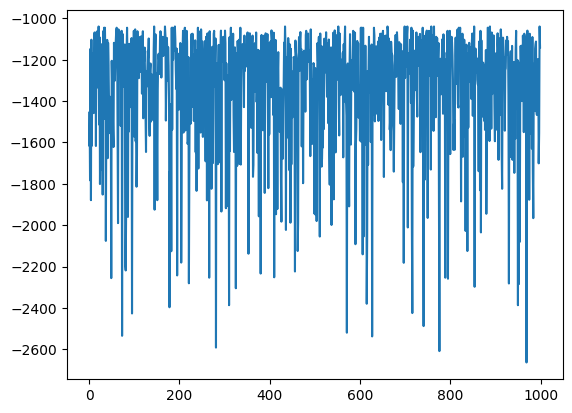

In [6]:
# Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

# Assignment Requirement 2: You need to complete the following method to visualize your training results.

With the Q table learned by the RL Learning algorithm above:

For each state $s(agentPos, boxPos)$  
The policy of agent at each state in the game is described as:
$\pi (s)=argmax_{a}Q(s, a)$  
$\pi(s)$ is used to visualize the optimal policy step by step, in the following visualize function.  

And the V value of each state $s(AgentPos, BoxPos)$ is:
$v_{\pi}(s)=q_{\pi}(s,\pi (s))$  
 

As per requested, the V value of each agent pos state $s^{'}(agentPos)$ is the average of all $v_{\pi}(agentPos)$ at all possible boxPos position to form the V-table:
$v^{'}(s^{'})=average(v_{\pi}(agentPos,boxPos))$ for all **boxPos**, when given a **agentPos**


The Function's implementation code as follows, 

In [7]:
def visualize(agent):
    # TODO: Visualize learned V-table and policy.
    # for ... in q_table.items():
    #     v_table[key[0]].append(np.mean(list(value.values())))
    #     policy[key[0]].append(actions[np.argmax([value[i] for i in range(1, 5)])])
    q_table = agent.q_table
    world_key = [(y, x) for y in range(agent.env.world_height) for x in range(agent.env.world_width)]
    v_table_with_box = {}
    policy_table = {}
    v_table = {}
    policy_pi = {}
    
    for key, value in q_table.items():
        agent_key = key[0:2]
        if key not in policy_pi.keys():
            policy_pi[key] = -1
        if key not in v_table_with_box.keys():
            v_table_with_box[key] = 0
        if agent_key not in v_table.keys():
            v_table[agent_key] = []
        #print("koi: ", agent_key)    
        actions = list(q_table[key].keys())
        policy_pi[key] = actions[np.argmax([value[i] for i in range(1, 5)])]
        v_table[agent_key].append(q_table[(key)][policy_pi[key]])
        #v_table[agent_key].append(np.max(list(value.values())))
        
    for agent_key, value in v_table.items():
        v_table[agent_key] = np.mean(v_table[agent_key])
    visualize_v(v_table, agent.env)
    visualize_policy(q_table, agent.env)
    return v_table, policy_pi

def visualize_v(v_table, env):
    V_y = {}
    print("V table:" )
    for y in range(env.world_height):
        V_y[y] = []
        keys = np.array(list(v_table.keys()))
        mask = keys[:,0] == y

        interested_keys = keys[mask]
        for k in interested_keys:
            V_y[y].append(round(v_table[tuple(k)],2))
        print(f"{y} {V_y[y]}")
    return V_y
    

def visualize_policy(q_table, oldenv):
    print("Learned policy:" )
    env = CliffBoxGridWorld(render=True, rewardengineering=oldenv.rewardengineering)
    state = env.reset()
    env.print_world()
    done = False
    rewards = []
    while not done:
        best_action = np.argmax([q_table[state][i] for i in range(1,5)])
        action_list = list(q_table[state].keys())
        action = action_list[best_action]

        # action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
        if oldenv.rewardengineering:
            state, reward, done, info = env.step_w_re(action, state)
        else:
            state, reward, done, info = env.step(action)
        rewards.append(reward)
        print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
        env.print_world()

    print(f'rewards: {sum(rewards)}')
    print(f'action history: {env.action_history}')        
 


# Train your own agent!

## About this assignment

During the evaluation of models, a model is said to have reach optimal convergence when it achieves the optimal trajectory it can possibly achieve. This optimal trajectory might not be the best of all methods.

For example:
The optimal trajectory for the below implemented Traditional Q-Learning is:  
```[(5, 0, 4, 1), (5, 1, 4, 1), (4, 1, 3, 1), (3, 1, 2, 1), (2, 1, 1, 1), (2, 0, 1, 1), (1, 0, 1, 1), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```  

The above trajectory would yield the greatest cumalative reward within one episode. (Cumulative Reward: 642, w/o Reward Engineering ) 
It is also the best possible trajectory possible for this project's problem. However, not all model will converge with a policy table that allows us to derive the above best possible trajectory like the above.

Some might end up with another optimal trajectory that might takes longer steps (Lesser Cumulative Reward) than the above such as:  

```[(5, 0, 4, 1), (4, 0, 4, 1), (4, 1, 4, 2), (5, 1, 4, 2), (5, 2, 4, 2), (4, 2, 3, 2), (3, 2, 2, 2), (2, 2, 1, 2), (2, 1, 1, 2), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```

The above trajectory would have yield cumulative reward of 623.

# First RL Implementation - Reinforcement Learning using Traditional Q-Learning taught by Prof Bo An

The below is a direct implementation of what was taught in Lecture 5 - Q-Learning. Learn rate $\alpha$ was deliberately set to 0.01 to increase the duration of training so that it can be benchmarked against the customized RL model I developed later. (Even though, the Q-Learning is able to learn the optimal policy in 6000 episodes at $\alpha=0.1$ )

With $\alpha=0.01$, the Q-Learning Model converges at **55000** episodes and completed 75000 episodes in **330** seconds.  
The agent reached saturation at around **55000** episodes in about approx **240** seconds ($330sec \times 55000episodes \div 75000episodes$)

In [8]:
# Traditional Q-Learning
import time

start = time.time()
episodes = 75000
env = CliffBoxGridWorld(rewardengineering=False)
env.reset()
agent1 = RLAgent(env, num_episodes=episodes, epsilon=0.01, alpha=0.01, gamma=0.99)
rewards_trad= agent1.learn(learning_algorithm = "q-learning")
time_taken = time.time() - start
print("Total time taken: ", time_taken)

Using reward engineering:  False
Total time taken:  303.97752046585083


### Learning Curve Visualization of traditional Q-Learning. Model converges at around 55000 episodes and completed 75000 episodes in about 330 seconds.


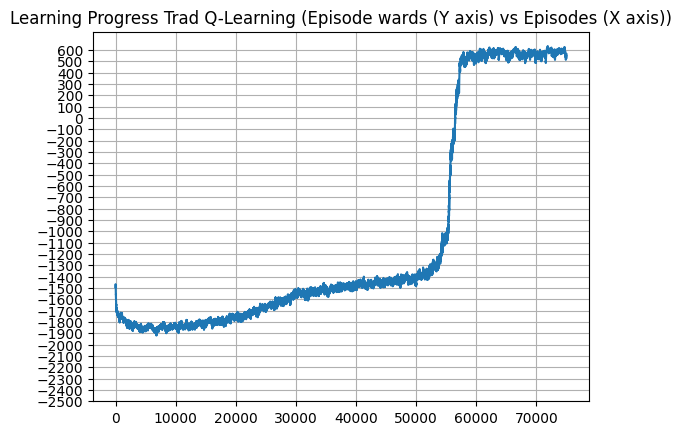

In [9]:
description = "Learning Progress Trad Q-Learning (Episode wards (Y axis) vs Episodes (X axis))"
plot_smooth_curve(weight=0.99, rewards=rewards_trad, description=description)

### Visualization of Learned V-table and Policy (Trad Q-Learning)

The optimal converged trajectory is:  

```[(5, 0, 4, 1), (5, 1, 4, 1), (4, 1, 3, 1), (3, 1, 2, 1), (2, 1, 1, 1), (2, 0, 1, 1), (1, 0, 1, 1), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```  

Final cumulative reward:**642**

In [10]:
# Visualization of V-Table and Policy from the direct implementation of Q-Learning model taught in AI6101 Lecture
v_table, policy = visualize(agent1)

V table:
0 [-35.56, -35.97, -36.93, -34.22, -30.42, -27.13, 0.0, 0.0, -29.82, -25.24, -24.34, -16.8, -14.59, -8.16]
1 [-27.6, -25.0, -26.05, -26.07, -26.37, -25.1, 0.0, 0.0, -25.14, -15.02, -14.72, -15.3, -10.71, -6.97]
2 [-30.8, -25.42, -31.47, 0.0, -28.48, -24.64, 0.0, 0.0, -28.07, -20.24, -15.88, -20.93, 0.0, -10.88]
3 [-34.05, -26.0, -35.07, 0.0, -27.69, -25.04, 0.0, -29.74, -28.73, -20.26, -16.49, 0.0, 0.0, -21.4]
4 [-34.89, -25.63, -33.9, 0.0, -24.5, -23.48, -22.1, -20.68, -19.12, -18.27, -17.86, 0.0, 0.0, -20.39]
5 [-31.29, -28.7, -37.15, 0.0, -33.3, -33.52, -32.88, -32.25, -27.96, -22.88, -18.15, 0.0, 0.0, -19.71]
Learned policy:
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' 

The following class defines the grid world environment. The grid world looks like:


# Problem with Traditional Q Learning


During training, I notice that the learning process at near certain position such as $State(4,7,3,7)$ can be really inefficient with current reward scheme which is too simple to tackle certain problems quickly. Example:

## Step 0:
State Current: (5,6,4,7) Provided Action: Right
```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|___|___|_x_|___|___|___|_B_|___|___|___|_x_|_x_|_G_|
|_5_|___|___|___|_x_|___|___|_A_|___|___|___|___|_x_|_x_|___|
```

State New: (5,7,4,7)
```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|___|___|_x_|___|___|___|_B_|___|___|___|_x_|_x_|_G_|
|_5_|___|___|___|_x_|___|___|___|_A_|___|___|___|_x_|_x_|___|
```

Update $Q(S_{0},A_{0})$ based on State New. Updates is insignificant which is fine. Agent have not make a critical mistake that will ruin the game yet. However, the following step as described below is different.



## Step 1:
State Current: (5,7,4,7) Provided Action: Up $A_{1}=Up$  
```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|___|___|_x_|___|___|___|_B_|___|___|___|_x_|_x_|_G_|
|_5_|___|___|___|_x_|___|___|___|_A_|___|___|___|_x_|_x_|___|
```

State New: (4,7,3,7)
```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|_B_|___|___|___|_x_|_x_|___|
|_4_|___|___|___|_x_|___|___|___|_A_|___|___|___|_x_|_x_|_G_|
|_5_|___|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```

The problem: 

Here the agent have make a move that have effectively ruined the game as the box is trapped at coordinate (3,7) now and we cant further push the box any further out of (3,7). The box is stuck indefinitely and can no longer reach the goal position, unless the game rule allow the agent to pull the box rather than just pushing.

However, update $Q(S_{1},A_{1})$ based on State New is still:

$Q_{new}(S_{1},A_{1}) = Q(S_{1},A_{1})+\alpha [R+\gamma max_{a}Q(S_{1+1},a)- Q(S_{1},A_{1})]$ is a insignificant update even though the process of $(S_{1},A_{1})$ is extremely undesirable.

As per the reward formulation, since the Box nor Agent have fell into the cliff, the Agent is not significantly far from the Agent, distance between Goal and Box/Agent is fine, scheme is very insignificant sum. Therefore relying on reward term alone will takes time before the model finds out that $Q(S_{1},A_{1})$ is an extremely undesirable state/action combination that will will just lead to endless situation of increasing timesteps with no progress.

Idea:

Currently as per Q-Learning Bellman's Equation formulation, $Q(S_{1},A_{1})$ only rely on Step 1's Reward term, plus the difference between value at new state, $argmax_{a}Q(S_{1}, a)$ and Step 1's original current state and action.  

We could make the model better by penalising $Q(S_{1},A_{1})$ greatly ASAP to speed up the learning process.  

We also know from manual observation, the update penalty of $Q(S_{1},A_{1})$ should be extremely bad as $S_{1},A_{1}$  since the situation at 2 time steps ago was much more desirable. (Refer to step 0 current state and new state). This term was not consider in the update of this Q value.  

Through this assignment I realise the model can learn how to handle such scenario faster, more specifically by learning certain tricky optimal $Q$ that are harder to learn like $Q(S_{1},A_{1})$ faster. This can be done by observing the $V$ value at $S_{new}$ is significant less valuable than current $S_{1}$ just like in the original Q-Learning algorithm, **togther with past tense before recent updates' $S_{1-1}$ and, $S_{1-2}$, etc, etc.** Information related to the states comparison can be stored in a list object from previous steps and used in later steps to update Q values by comparing Q  value distant past and new states from this current states/actions. In the next section of the repoort, I will discuss more how I implement the customized version of the original Q-Learning.  


## Solution Development of my own Custom Q-Learning - Incorporating Data-Centric AI methodology into Q-Learning Reinforcement Learning

### Instead of learning with only Current state and action, learn with History Past data as training data as well

Instead of just Learning the Regret from current State and Action produced Resulting Observation, Learn the Regret with both historical past and current "States / Actions produced Resulting Observation":  

For this project I propose the idea to modify the Q-value update rule by implementing new terms to compare the historical states/actions at state 0 or/and older past, $p-1$ states/actions.

For example, given $p=3$, to consider current state/action plus two historical past state/action, given a current state at step $t$:  
If the new state/action V value, $argmax_{a}Q(S_{t+1},a)$ is way less desirable than the older steps' $Q$ such as, $Q(S_{t},A_{t})$ and/or $Q(S_{t-1},A_{t-1})$ then the update of $Q(S_{t},A_{t})$ should receive a more significant negative reward without hesistant.

The Q Learning's Q Table update for a current State/Action $(S_{t},A_{t})$ with the Customized Q-Learning Bellman Equation formulation is modified as followed:

$Q_{new}(S_{t},A_{t}) = Q(S_{t},A_{t})+\alpha [R+\gamma max_{a}Q(S_{t+1},a)- P^{T}H]$

Where given two new constant parameters $r$ (usually 0.1 in the experiment) is the weight decay factor, and $p$ is the number of historical pasts to consider, we form the following two vectors:  
$P$ is a p by 1 vector where $P=[\rho _{0}=r^{p},  \rho _{1}=r^{p-1},  ...,   \rho _{p-1}=r^{p-p}=1.0]^{T}$  
$H$ is a p by 1 vector where $H=[Q(S_{t-p},A_{t-p}),Q(S_{t-p+1},A_{t-p+1}),  ...,  Q(S_{t},A_{t})]^{T}$

The new hyperparameters $p$ must be: $1<=p$ and $r$ must be: $0<r<1.0$. The above 2 are essentially regularization hyperparameters to control how seriously the model refer to the past states in additional to the original Bellman's equation. $H$ is a vector that stores the historical terms of the new state which also includes the current $(Q(S_{t}, A_{t})$ term which is also present in the original Q-Learning Bellman equation. The $H$ vector is essential the training vector generated at previous episodes and steps for this current step Q update. 

For the rest of the assignment I refer to this model as the **pQ-Learning** RL learning algorithm, where the additional p in front stand from "past" or "history" Q-Learning. 


### DRAWBACKS:
Even though the Custom pQ-Learning I implemented can achieve convergence way more quicker than Q-Learning, using the current Reward scheme as per the assignment's default MDP formulation, we can note that the model is unable to converge at the best possible optimal trajectory.


During experiment, the trajectory of the converged episodes of the Custom p Q-Learning is:  

```[(5, 0, 4, 1), (4, 0, 4, 1), (4, 1, 4, 2), (5, 1, 4, 2), (5, 2, 4, 2), (4, 2, 3, 2), (3, 2, 2, 2), (2, 2, 1, 2), (2, 1, 1, 2), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```  

Above trajectory yields Cumulative Reward: **623**  
This is unfortunately not the optimal shortest trajectory possible. (Refer to the optimal trajectory of Traditional Q-Learning for better optimal which has Cumulative Reward of **642**). Optimally best, the first two steps should be (Right to 5,1,4,1) followed by (Up to 4,1,3,1).

First few steps in the episode might not be optimal as the Bellman's Q Value do not have any meaningful past steps Q value to take reference from last subsequent steps. Currently implementation initialize H as a 0 vector for the first step update which might not be best implementation. Nonetheless, any subsequent movement after the first 2 steps are optimally best possible.

In order to achieve the best possible optimal trajectory, later in this project, I also conducted reward engineering on the current reward scheme such that it reward agent based on smart or stupid actions rather than just based on the direct distance of box/agents and the timesteps it takes to reach the goal. This will also allow us to converge at the best possible optimal trajectory.   


### Final Algorithm Design of pQ-Learning:

&nbsp; &nbsp; Algorithm parameters: step size $\alpha$  $\epsilon$  $[0,1]$, small $\varepsilon$ > $0$  
&nbsp; &nbsp; Initialize $Q(s,a)$, for all $s$ $\epsilon$ $S^{+}$, $a$ $\epsilon$ $A(s)$, arbitrarily except that $Q(terminal,.)=0$  
&nbsp; &nbsp; Initialize Weight Decaying constant vector $P=[\rho _{0}=r^{p},  \rho _{1}=r^{p-1},  ...,   \rho _{p-1}=r^{p-p}=1.0]^{T}$  

&nbsp; &nbsp; Loop for each episode:  
&nbsp; &nbsp; &nbsp; Initialize env $S$  
&nbsp; &nbsp; &nbsp; Initialize Initialize $H$ as zero vector of shape $p$ by 1.  $H$ $\epsilon$ $\mathbb{R}^{p}$  
&nbsp; &nbsp; &nbsp; Loop for each step of episode:  
&nbsp; &nbsp; &nbsp; &nbsp; Choose $A$ from $S$ using policy derived from $Q$ (From default code's $\varepsilon$ - greedy)  
&nbsp; &nbsp; &nbsp; &nbsp; Update $P$ records by deleting oldest (first) record and appending the $Q$ value of current state/action:  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $H \leftarrow H[1:].append(Q(S,A))$  
&nbsp; &nbsp; &nbsp; &nbsp; Take action $A$, observe $R$, $S^{'}$  
&nbsp; &nbsp; &nbsp; &nbsp; $Q(S,A)\leftarrow Q(S,A) + \alpha [R+ \gamma max_{a} Q(S^{'}, a) - P^{T}H]$   
&nbsp; &nbsp; &nbsp; &nbsp; $S\leftarrow S^{'}$  
&nbsp; &nbsp; &nbsp; until $S$ is terminal


**Implementation Experiment is as followed:**


# Second RL Implementation: Testing my Custom pQ-Learning
## We test the new Q update formulation by setting p=2 
When $p=2$, this means we consider historical $Q(S_{t-1}, A_{t-1})$ and current which the original Q learning emcompass, $Q(S_{t}, A_{t})$ )

Customized Q Learning Bellman Equation formulation:  
$Q(S_{t},A_{t})_{new}=Q(S_{t},A_{t})+\alpha [R+\gamma max_{a}Q(S_{t+1},a)-r_{0}Q(S_{t-1},A_{t-1})-r_{1}Q(S_{t},A_{t} )]$  
where the last $r: r_{p-1}=r_{1}=1.0$ for all given p constant

In the run time below, my Custom p=2 Q-Learning take approx **350 to 400** seconds (fluctuates around) to execute 75000 episodes at a rate of about **188 episodes/second**. The agent reached saturation at around **34000** episodes in about **180** seconds.  (Approx: $34000 episodes \times 380sec \div 75000 episodes$).

We can notice that the extra computation does not result in significant increased in training duration to complete 75000 episodes. This is thanks to Modern Computing packages like Numpy. NumPy computing can use highly optimized techniques to speed up matrix operations. This helps to moderate the training duration relative to original Q-Learning

In [11]:
# Guang Way's Custom Q-Learning
import time

start = time.time()
episodes = 75000
p=2
r = 0.1
env = CliffBoxGridWorld(rewardengineering=False)
env.reset()
agent2 = RLAgent(env, num_episodes=episodes, epsilon=0.01, alpha=0.01, gamma=0.99, p=p, r = r)
rewards_custom = agent2.learn(learning_algorithm = "custom q-learning")
time_taken = time.time() - start
print("Total time taken: ", time_taken)
#print(f"Speed: {episodes / (time.time() - start)} episodes/sec")

Using reward engineering:  False
Total time taken:  358.3728187084198



### Learning Curve: Setting p=2, 
The model converges at **35000** episodes

The $Q(S,A)$ update formulation are as followed in this training:
$Q(S_{t},A_{t})_{new}=Q(S_{t},A_{t})+\alpha [R+\gamma max_{a}Q(S_{t+1},a)-r_{0}Q(S_{t-1},A_{t-1})-r_{1}Q(S_{t},A_{t} )]$  
The agent reached saturation at around **35000** episodes in about **180** seconds 


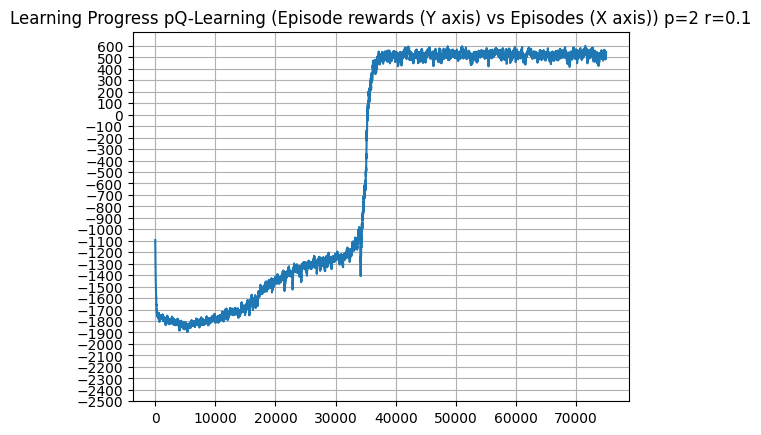

In [12]:
description = 'Learning Progress pQ-Learning (Episode rewards (Y axis) vs Episodes (X axis)) p=2 r=0.1'
plot_smooth_curve(weight=0.99, rewards=rewards_custom, description=description)

### Visualization of Learned V-table and Policy (custom pQ-learning with p=2 r=0.1)

The optimal converged trajectory is not the best possible (in terms of cumulative reward). It is as follows:  

```[(5, 0, 4, 1), (4, 0, 4, 1), (4, 1, 4, 2), (5, 1, 4, 2), (5, 2, 4, 2), (4, 2, 3, 2), (3, 2, 2, 2), (2, 2, 1, 2), (2, 1, 1, 2), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```

Final cumulative reward: **623**

In [13]:
# Visualization of V-Table and Policy from the direct implementation of custom pQ-Learning with p=2, r=0.1
v_table2, policy2 = visualize(agent2)

V table:
0 [-17.48, -17.45, -17.78, -17.52, -17.72, -16.9, 0.0, 0.0, -13.59, -10.01, -9.06, -3.17, -2.8, 4.83]
1 [-17.17, -15.72, -16.15, -16.53, -16.61, -16.14, 0.0, 0.0, -10.43, -4.7, -3.37, -1.35, 1.89, 7.0]
2 [-17.33, -16.13, -16.03, 0.0, -16.28, -16.28, 0.0, 0.0, -11.69, -9.57, -5.83, -6.29, 0.0, 2.26]
3 [-17.42, -15.79, -15.98, 0.0, -16.6, -15.76, 0.0, -14.93, -14.09, -7.36, -8.92, 0.0, 0.0, -7.74]
4 [-17.01, -15.82, -15.79, 0.0, -15.02, -14.72, -14.1, -13.01, -11.84, -10.41, -9.13, 0.0, 0.0, -7.05]
5 [-16.94, -17.01, -16.91, 0.0, -17.11, -16.96, -16.46, -15.68, -13.16, -12.81, -10.14, 0.0, 0.0, -6.58]
Learned policy:
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b

# Learning with Custom Q where p=3, 
Setting $p = 3$, we notice tiny convergence rate improvement as relative to p=2.  

Customized Q Learning Bellman Equation formulation: 
$Q(S_{t},A_{t})_{new}=Q(S_{t},A_{t})+\alpha [R+\gamma max_{a}Q(S_{t+1},a)-r_{0}Q(S_{t-2},A_{t-2}) -r_{1}Q(S_{t-1},A_{t-1})-r_{2}Q(S_{t},A_{t} )]$  
where the last $r: r_{p-1}=r_{2}=1.0$ for all given p constant

Converges at **35000** episodes  and completed 75000 episodes also in about **350-400** seconds. The agent reached saturation at around **35000** episodes in about **180** seconds

In [24]:
# Guang Way's Custom Q-Learning
import time

start = time.time()
episodes = 75000
p=3
r = 0.1
env = CliffBoxGridWorld(rewardengineering=False)
env.reset()
agent3 = RLAgent(env, num_episodes=episodes, epsilon=0.01, alpha=0.01, gamma=0.99, p=p, r = r)
rewards_custom3 = agent3.learn(learning_algorithm = "custom q-learning")
time_taken = time.time() - start
print("Total time taken: ", time_taken)
# print(f"Speed: {episodes / (time.time() - start)} episodes/sec")

Using reward engineering:  False
Total time taken:  348.51920676231384


## Learning Curve: Setting p=3 also can allow us to achieve a tiny improvement. 

Q value update formulation:  
$Q(S_{t},A_{t})_{new}=Q(S_{t},A_{t})+\alpha [R+\gamma max_{a}Q(S_{t+1},a)-r_{0}Q(S_{t-2},A_{t-2}) -r_{1}Q(S_{t-1},A_{t-1})-r_{2}Q(S_{t},A_{t} )]$  

The improvement achieved is not significant. The model converged in about **35000** episodes and completed 75000 episodes in **350-400** seconds. This indicate that: Given time step $t$, the historical record $t-2$ or older is nowhere as significant as $t-1$. The runtime of this run is the same as the case in $p=2$ and $p=4$. Increasing p constant moderately does not affect the overall runtime significantly. The agent reached saturation at around **35000** episodes in about **180** seconds 

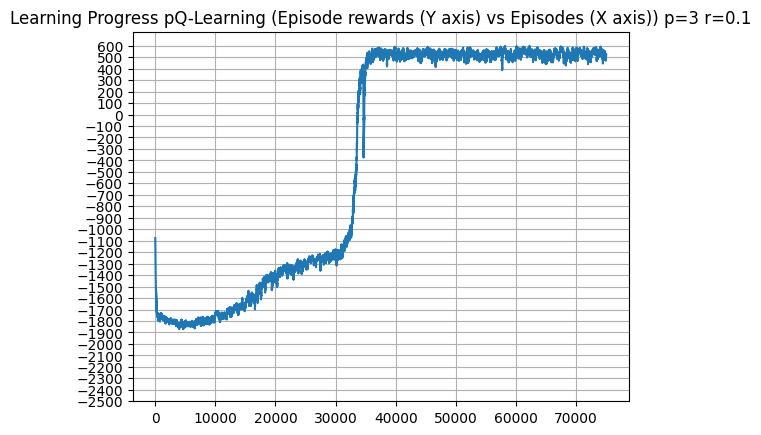

In [15]:
description = 'Learning Progress pQ-Learning (Episode rewards (Y axis) vs Episodes (X axis)) p=3 r=0.1'
plot_smooth_curve(weight=0.99, rewards=rewards_custom3, description=description)

### Visualization of Learned V-table and Policy (custom pQ-learning with p=3 r=0.1)

The optimal converged trajectory is not the best possible as well(in terms of cumulative reward). It is as follows:  

```[(5, 0, 4, 1), (4, 0, 4, 1), (4, 1, 4, 2), (5, 1, 4, 2), (5, 2, 4, 2), (4, 2, 3, 2), (3, 2, 2, 2), (2, 2, 1, 2), (2, 1, 1, 2), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```

Final cumulative reward: **623**


In [16]:
# Visualization of V-Table and Policy from the direct implementation of custom pQ-Learning model with p=3 r=0.1
v_table3, policy3 = visualize(agent3)

V table:
0 [-16.44, -16.47, -16.79, -16.61, -16.79, -16.22, 0.0, 0.0, -12.61, -9.07, -8.17, -2.45, -2.01, 5.75]
1 [-16.25, -14.91, -15.29, -15.71, -15.82, -15.35, 0.0, 0.0, -8.68, -4.46, -2.65, -0.64, 3.3, 7.24]
2 [-16.31, -15.22, -15.2, 0.0, -15.48, -15.49, 0.0, 0.0, -12.11, -8.87, -5.38, -5.63, 0.0, 3.08]
3 [-16.35, -14.93, -15.08, 0.0, -15.76, -15.01, 0.0, -14.02, -13.37, -6.48, -8.25, 0.0, 0.0, -6.92]
4 [-16.01, -14.86, -14.88, 0.0, -14.38, -14.2, -13.38, -12.28, -11.21, -9.85, -8.3, 0.0, 0.0, -6.28]
5 [-15.97, -16.05, -15.94, 0.0, -16.23, -15.98, -15.54, -14.87, -12.42, -12.07, -9.26, 0.0, 0.0, -5.84]
Learned policy:
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A

## Learning with Custom pQ-Learning where p=4

Customized Q Learning Bellman Equation formulation:
$Q(S_{t},A_{t})_{new}=Q(S_{t},A_{t})+\alpha [R+\gamma max_{a}Q(S_{t+1},a)-r_{0}Q(S_{t-3},A_{t-3})-r_{1}Q(S_{t-2},A_{t-2}) -r_{2}Q(S_{t-1},A_{t-1})-r_{3}Q(S_{t},A_{t} )]$
where the last $r: r_{p-1}=r_{3}=1.0$ for all given p constant

Setting p=4 does not result in no significant improvement, the learning outcome wasn't harmed as well. The model converge at **34000** episodes and completed 75000 episodes in **350-400** seconds. The agent reached saturation at around **34000** episodes in about **176.9** seconds 


In [25]:
# Guang Way's Custom Q-Learning
import time

start = time.time()
episodes = 75000
p=4
r = 0.1
env = CliffBoxGridWorld(rewardengineering=False)
env.reset()
agent4 = RLAgent(env, num_episodes=episodes, epsilon=0.01, alpha=0.01, gamma=0.99, p=p, r = r)
rewards_custom4 = agent4.learn(learning_algorithm = "custom q-learning")
time_taken = time.time() - start
print("Total time taken: ", time_taken)
# print(f"Speed: {episodes / (time.time() - start)} episodes/sec")

Using reward engineering:  False
Total time taken:  360.4449496269226


### Learning Curve Visualization when setting p=4, 

At $p=4$ can be noted the result doesnt differ alot from $p=3$

Customized Q Learning Bellman Equation formulation:
$Q(S_{t},A_{t})_{new}=Q(S_{t},A_{t})+\alpha [R+\gamma max_{a}Q(S_{t+1},a)-r_{0}Q(S_{t-3},A_{t-3})-r_{1}Q(S_{t-2},A_{t-2}) -r_{2}Q(S_{t-1},A_{t-1})-r_{3}Q(S_{t},A_{t} )]$

It appears that the historical record from Time Step $T-3$ has no direct implication on Time Step $T$ for this specific problem. However neither does increasing $p$ constant beyond optimal does any harm to the convergence rate. The agent reached saturation at around **34000** episodes in about **176.9** seconds

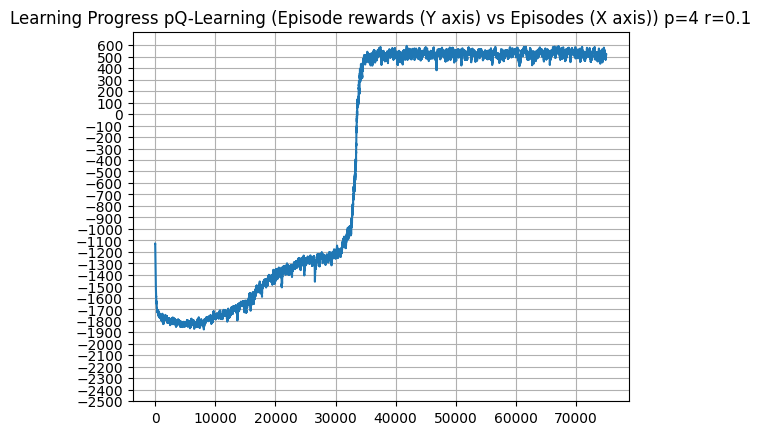

In [26]:
description = 'Learning Progress pQ-Learning (Episode rewards (Y axis) vs Episodes (X axis)) p=4 r=0.1'
plot_smooth_curve(weight=0.99, rewards=rewards_custom4, description=description)

### Visualization of Learned V-table and Policy (custom pQ-learning with p=4 r=0.1)
The optimal converged trajectory is not the best possible as well(in terms of cumulative reward). It is as follows:  

```[(5, 0, 4, 1), (4, 0, 4, 1), (4, 1, 4, 2), (5, 1, 4, 2), (5, 2, 4, 2), (4, 2, 3, 2), (3, 2, 2, 2), (2, 2, 1, 2), (2, 1, 1, 2), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```

Final cumulative reward: **623**

In [19]:
# Visualization of V-Table and Policy from the direct implementation of custom pQ-Learning with p=4, r=0.1
v_table4, policy4 = visualize(agent4)

V table:
0 [-16.28, -16.29, -16.63, -16.44, -16.59, -15.96, 0.0, 0.0, -12.44, -8.83, -8.21, -2.7, -1.93, 6.01]
1 [-16.05, -14.76, -15.13, -15.55, -15.56, -15.27, 0.0, 0.0, -9.29, -3.91, -2.34, -0.68, 2.79, 7.37]
2 [-16.16, -15.08, -15.08, 0.0, -15.31, -15.26, 0.0, 0.0, -11.07, -8.65, -5.27, -5.32, 0.0, 3.16]
3 [-16.23, -14.81, -14.99, 0.0, -15.59, -14.97, 0.0, -13.96, -13.01, -6.45, -7.82, 0.0, 0.0, -6.83]
4 [-15.88, -14.73, -14.78, 0.0, -14.22, -14.05, -13.27, -12.33, -11.19, -9.8, -8.09, 0.0, 0.0, -6.19]
5 [-15.83, -15.92, -15.79, 0.0, -15.97, -15.79, -15.46, -14.62, -12.2, -11.92, -9.14, 0.0, 0.0, -5.73]
Learned policy:
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'

## Development of Improved Agent that learns using the Custom pQ-Learning with reformulated Reward scheme
As per discussed prior to the above implementation/visualization, the Custom pQ-Learning has the trajectory of converged episodes as follows:

```
[(5, 0, 4, 1), (4, 0, 4, 1), (4, 1, 4, 2), (5, 1, 4, 2), (5, 2, 4, 2), (4, 2, 3, 2), (3, 2, 2, 2), (2, 2, 1, 2), (2, 1, 1, 2), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]
```

Above trajectory yields Cumulative Reward: **623**  
This is unfortunately not the optimal shortest trajectory possible like the one Traditional Q-Learning achieved.  
To resolve the issue, for the last part of my RL implementation, I conducted reward engineering on the current reward scheme such that it reward agent based on smart or stupid actions rather than just based on the direct distance of box/agents and the timesteps it takes to reach the goal. 

For example:  
1. Movement that does not involves pushing the box are penalized with negative rewards, so the RL agent will not be able to achieve decent cumulative reward if it spends too much time pondering around the box without any intention to move it when its near the goal post.  

2. Movement that involves moving away from the box further when Agent is already next to the box is also penalized heavily as the goal is actually as the following 2:  
    1. To move Agent position to the Box  
    2. To move the Box until it reach the Goal position  

    Therefore any steps that involves moving away from the box would be consider breach of the first goal and definitely not the optimal trajectory anymore and hence ends the game. 

## Using Custom p=2 Q-Learning Incorporated with Reward Engineering to further speed up learning
Model converges and achieved optimal trajectory at about episode **21000** at the best trajectory possible. (Similar to Traditional Q-Learning)  
```[(5, 0, 4, 1), (5, 1, 4, 1), (4, 1, 3, 1), (3, 1, 2, 1), (2, 1, 1, 1), (2, 0, 1, 1), (1, 0, 1, 1), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```  

The above optimal trajectory yields cumulative reward of **577**. The main trick to ensure that the new modified Custom pQ-Learning achieve best possible optimal trajectory is to set a greater penalty reward for movement that does not involves pushing the box, so that the Model reduces focus on the Box/Agent's distance to the goal. Reason being is that, in the early phase of the game, such attributes are less important than being able to get the box to start moving first.

The model completed running **75,000** episodes in in about **300** seconds. Since it takes about **20000** episodes to converges, convergence is achieved at approx **80** seconds. About **2 times faster than the original Custom pQ-Learning and 3 times faster than the original Traditional Q-Learning**, when both are without Reward engineering. (approx **180** and **240** seconds respectively)

In [20]:
# Guang Way's Custom Q-Learning with Reward Engineering
import time

start = time.time()
episodes = 75000
p=2
r = 0.1
env = CliffBoxGridWorld(rewardengineering=True) # Set this to True to activate my custom implemented reward engineering
env.reset()
agent5 = RLAgent(env, num_episodes=episodes, epsilon=0.01, alpha=0.01, gamma=0.99, p=p, r=r)
rewards_custom_re = agent5.learn(learning_algorithm = "custom q-learning")
print("Total time taken: ", time.time() - start)

Using reward engineering:  True
Total time taken:  347.53932452201843


### Learning Curve: Setting p=2, 
##### The model converges at 21000 episodes in approx 92.4 seconds. 
This is the best model we achieved by the custom innovation. (In terms of training speed)

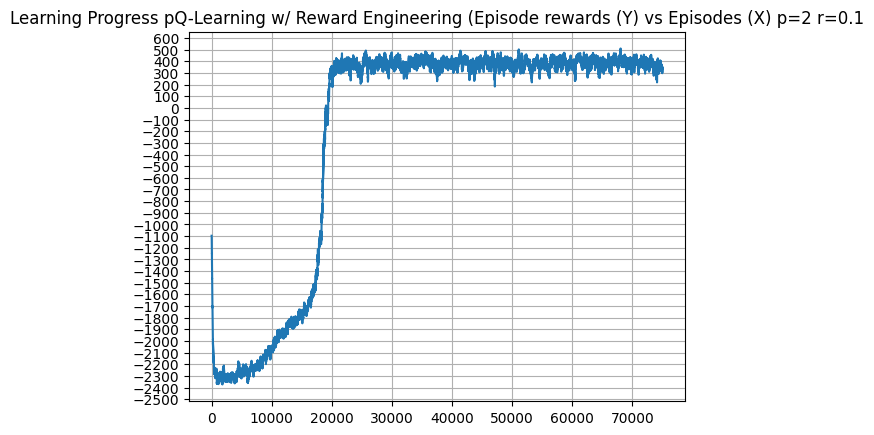

In [21]:
description = 'Learning Progress pQ-Learning w/ Reward Engineering (Episode rewards (Y) vs Episodes (X) p=2 r=0.1'
plot_smooth_curve(weight=0.99, rewards=rewards_custom_re, description=description)

### Visualization of Learned V-table and Policy (custom pQ-learning with p=2 r=0.1 w/ Reward engineering)

Now the model converged at the best possible trajectory like the original q-learning did:

```[(5, 0, 4, 1), (5, 1, 4, 1), (4, 1, 3, 1), (3, 1, 2, 1), (2, 1, 1, 1), (2, 0, 1, 1), (1, 0, 1, 1), (1, 1, 1, 2), (1, 2, 1, 3), (1, 3, 1, 4), (1, 4, 1, 5), (0, 4, 1, 5), (0, 5, 1, 5), (1, 5, 2, 5), (2, 5, 3, 5), (3, 5, 4, 5), (3, 4, 4, 5), (4, 4, 4, 5), (4, 5, 4, 6), (4, 6, 4, 7), (4, 7, 4, 8), (4, 8, 4, 9), (4, 9, 4, 10), (5, 9, 4, 10), (5, 10, 4, 10), (4, 10, 3, 10), (3, 10, 2, 10), (2, 10, 1, 10), (2, 9, 1, 10), (1, 9, 1, 10), (1, 10, 1, 11), (1, 11, 1, 12), (1, 12, 1, 13), (0, 12, 1, 13), (0, 13, 1, 13), (1, 13, 2, 13), (2, 13, 3, 13)]```

Final cumulative reward **642**

In [22]:
# Visualization of V-Table and Policy from the direct implementation of custom pQ-Learning with p=2, r=0.1
v_table5, policy5 = visualize(agent5)

V table:
0 [-15.09, -15.39, -15.77, -15.69, -14.98, -14.27, 0.0, 0.0, -9.05, -5.21, -3.86, -2.67, 2.14, 3.82]
1 [-14.94, -14.02, -14.49, -14.41, -13.69, -13.55, 0.0, 0.0, -8.9, -4.1, -2.77, -0.95, 8.21, 5.1]
2 [-15.11, -13.99, -14.61, 0.0, -13.13, -13.96, 0.0, 0.0, -10.46, -5.7, -1.21, -0.16, 0.0, 6.86]
3 [-15.21, -14.49, -14.83, 0.0, -13.48, -12.62, 0.0, -10.47, -9.87, -3.34, -6.18, 0.0, 0.0, -3.45]
4 [-15.48, -14.3, -14.5, 0.0, -12.52, -12.61, -11.53, -10.38, -9.5, -6.02, -6.64, 0.0, 0.0, -3.04]
5 [-15.51, -15.58, -15.74, 0.0, -13.28, -13.31, -12.61, -11.58, -10.66, -8.56, -7.45, 0.0, 0.0, -2.76]
Learned policy:
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b

# Conclusion

The assignment ends here after we have trained the above pQ-Learning RL agent with reward engineering. Through this assignment I learned to implement the Q-Learning RL algorithm taught in class. I also discovered that some modification can be done on the Bellman's Equation to achieve greater convergence rate by remembering historical data to train and learn the optimal action for later steps.  

It is proven that for this assignment's application, the custom technique learns faster. To prove so, in this assignment the learnrate $\alpha $ was reduced from optimally 0.1 to 0.01 to slow down the Learning Algorithms' learning curve so that we can benchmark performance against each other. the pQ-Learning model of all $p$ and $r$ settings significannt out performances. (Converging with about 2 to 3 times lesser episodes.) This comes with a cost of just about 0-25% longer duration to cover 75,000 episodes.   


# Possible future upgrade on Algorithm
Similar implementation might also be possible with other RL algorithm that was taught in AI6101 such as SARSA which is relatively similar to Q-Learning. 

Some of the formulation in this implementation such as weight decay vector $P$, and how $H$ was initialized at the start of every episode may be improved too. 

However due to tight deadlines together with many other assignments in the Masters Program, I did not attempt further investigation. Possible furture work may consider these aspects.   


In [23]:
!jupyter nbconvert --to pdf .\AI6101_Code_TengGuangWay_G2102434F.ipynb

[NbConvertApp] Converting notebook .\AI6101_Code_TengGuangWay_G2102434F.ipynb to pdf
[NbConvertApp] Support files will be in AI6101_Code_TengGuangWay_G2102434F_files\
[NbConvertApp] Making directory .\AI6101_Code_TengGuangWay_G2102434F_files
[NbConvertApp] Making directory .\AI6101_Code_TengGuangWay_G2102434F_files
[NbConvertApp] Making directory .\AI6101_Code_TengGuangWay_G2102434F_files
[NbConvertApp] Making directory .\AI6101_Code_TengGuangWay_G2102434F_files
[NbConvertApp] Making directory .\AI6101_Code_TengGuangWay_G2102434F_files
[NbConvertApp] Writing 234122 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 375750 bytes to AI6101_Code_TengGuangWay_G2102434F.pdf
